In [1]:
import wget

In [5]:
# download data from provided
https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

-1 / unknown

'AirlineTweets.csv'

In [2]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('AirlineTweets.csv')

In [4]:
df = df[['airline_sentiment','text']]

<Axes: >

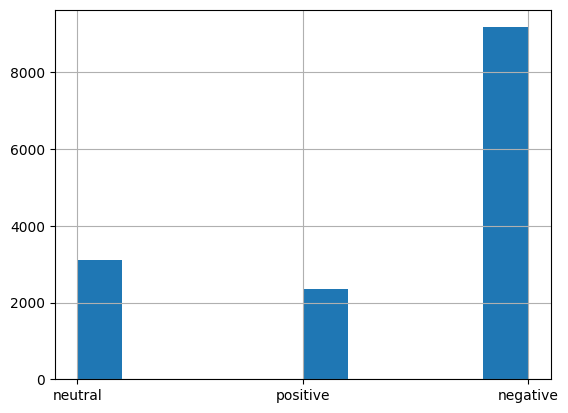

In [5]:
df['airline_sentiment'].hist()

In [6]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [7]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [8]:
json_data = df1.to_json()

In [45]:
from datasets import Dataset, load_dataset

In [50]:
raw_dataset = load_dataset(path='csv',data_files = 'data.csv')

Found cached dataset csv (file://C:/Users/Yuvaraj S/.cache/huggingface/datasets/csv/default-c267b38c8f8a39ac/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

In [10]:
from ast import literal_eval

elements = literal_eval(json_data)

In [52]:
raw_data = Dataset.from_pandas(df1)

In [54]:
split = raw_data.train_test_split(test_size=0.3, seed=42)

In [56]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [57]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

In [58]:
def tokenize_fn(batch):
    return tokernizer(batch['sentence'], truncation = True)

In [59]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [60]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [61]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install torchinfo

In [62]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   22,268,928
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [63]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

C:\Yashwanth\Jupyter\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
!pip 

^C
Note: you may need to restart the kernel to use updated packages.


In [65]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [66]:
tokenized_dataset['train']

Dataset({
    features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10248
})

In [67]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

In [68]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 